### Установка и подключение библиотек

In [ ]:
!pip install optuna

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.1 MB/s eta 0:00:00


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold
from sklearn.base import clone

import optuna

### Вспомогательные функции

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def make_csv_result(proba, ids, name):
    answer = pd.DataFrame(data=ids.index, columns=["id"])
    answer['score'] = proba
    answer.set_index('id', inplace=True)
    answer.to_csv(f'{name}.csv')
    print(answer)

## Данные
Использовал датасет https://www.kaggle.com/competitions/fintech-credit-scoring/data

Добавим две таблицы оттуда и изучим их

In [ ]:
data = pd.read_csv("./sample_data/application_info.csv")
default = pd.read_csv("./sample_data/default_flg.csv")

In [ ]:
print(data.info(), default.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205296 entries, 0 to 205295
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               205296 non-null  int64  
 1   application_dt   205296 non-null  object 
 2   sample_cd        205296 non-null  object 
 3   education_cd     204384 non-null  object 
 4   gender_cd        205296 non-null  object 
 5   age              205296 non-null  int64  
 6   car_own_flg      205296 non-null  object 
 7   car_type_flg     205296 non-null  object 
 8   appl_rej_cnt     205296 non-null  int64  
 9   good_work_flg    205296 non-null  int64  
 10  Score_bki        205296 non-null  float64
 11  out_request_cnt  205296 non-null  int64  
 12  region_rating    205296 non-null  int64  
 13  home_address_cd  205296 non-null  int64  
 14  work_address_cd  205296 non-null  int64  
 15  income           205296 non-null  int64  
 16  SNA              205296 non-null  int6

## Features



#### Работа с датой 'application_dt'

In [ ]:
data['application_dt'] = pd.to_datetime(data['application_dt'])

# print(df_tmp['application_dt'].year)
data['application_year'] = data['application_dt'].dt.year
data['application_month'] = data['application_dt'].dt.month
data['application_day'] = data['application_dt'].dt.day
data['application_weekday'] = data['application_dt'].dt.weekday
# Можно добавить другие признаки, например, квартал, день месяца и т.д.
data.drop('application_dt', axis=1, inplace=True)


#### education_cd

In [ ]:
onehotencoder = OneHotEncoder()
educations = pd.DataFrame(data['education_cd'].fillna("other"))
data_new = onehotencoder.fit_transform(educations)
print(onehotencoder.categories_)

education_one_hot = pd.DataFrame(data_new.toarray(),
columns=onehotencoder.categories_)
data.drop('education_cd', axis=1, inplace=True)
data = pd.concat([data, education_one_hot], axis=1)
data

[array(['ACD', 'GRD', 'PGR', 'SCH', 'UGR', 'other'], dtype=object)]


,id,sample_cd,gender_cd,age,car_own_flg,car_type_flg,appl_rej_cnt,good_work_flg,Score_bki,out_request_cnt,...,application_year,application_month,application_day,application_weekday,"(ACD,)","(GRD,)","(PGR,)","(SCH,)","(UGR,)","(other,)"
0,1,train,M,27,Y,Y,0,0,-1.917831,0,...,2014,1,1,2,0.0,0.0,0.0,1.0,0.0,0.0
1,2,train,F,26,N,N,0,0,-1.153144,2,...,2014,1,1,2,0.0,1.0,0.0,0.0,0.0,0.0
2,3,train,M,35,N,N,0,1,-1.732810,0,...,2014,1,1,2,0.0,0.0,0.0,1.0,0.0,0.0
3,4,train,F,35,N,N,0,1,-2.552133,2,...,2014,1,1,2,0.0,1.0,0.0,0.0,0.0,0.0
4,5,train,F,24,N,N,0,0,-1.914581,1,...,2014,1,1,2,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205291,205292,test,F,24,N,N,0,1,-2.001592,0,...,2015,3,31,1,0.0,0.0,0.0,0.0,1.0,0.0
205292,205293,test,F,48,N,N,2,1,-2.088683,3,...,2015,3,31,1,0.0,0.0,0.0,1.0,0.0,0.0
205293,205294,test,F,33,Y,Y,0,1,-2.140081,2,...,2015,3,31,1,0.0,1.0,0.0,0.0,0.0,0.0
205294,205295,test,M,27,Y,Y,1,0,-1.552576,0,...,2015,3,31,1,0.0,0.0,1.0,0.0,0.0,0.0


#### gender, car_own_flag, car_type_flag, air_flg

In [ ]:
data['gender_cd'] = (data['gender_cd'] == "M").astype(int)
data['car_own_flg'] = (data['car_own_flg'] == "Y").astype(int)
data['car_type_flg'] = (data['car_type_flg'] == "Y").astype(int)
data['Air_flg'] = (data['Air_flg'] == "Y").astype(int)

In [ ]:
data.rename(columns={
    data.columns[-1] : 'edu_type_other',
    data.columns[-2] : 'edu_type_ugr',
    data.columns[-3] : 'edu_type_sch',
    data.columns[-4] : 'edu_type_pgr',
    data.columns[-5] : 'edu_type_grd',
    data.columns[-6] : 'edu_type_acd',
    }, inplace=True)


#### home_address_cd, word_address_cd

In [ ]:
data.drop('sample_cd', axis=1, inplace=True)

##### Преодобработка

In [ ]:
numerical_features = ['age', 'appl_rej_cnt', 'Score_bki', 'out_request_cnt', 'income',
                      'application_year', 'application_month', 'application_day', 'application_weekday']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features)
    ])

data_preprop = preprocessor.fit_transform(data)

num_data = pd.DataFrame(data_preprop, columns=numerical_features)
# data = pd.DataFrame(X_test, columns=feature_names)

data.drop(columns=numerical_features, axis=1, inplace=True)
data = pd.concat([data, num_data], axis=1)
data

,id,gender_cd,car_own_flg,car_type_flg,good_work_flg,region_rating,home_address_cd,work_address_cd,SNA,first_time_cd,...,edu_type_other,age,appl_rej_cnt,Score_bki,out_request_cnt,income,application_year,application_month,application_day,application_weekday
0,1,1,1,1,0,40,2,3,1,4,...,0.0,-1.078909,-0.354241,0.100991,-0.942610,-0.226895,-0.367949,-1.288238,-1.742180,-0.347265
1,2,0,0,0,0,60,2,3,2,1,...,0.0,-1.166237,-0.354241,1.667798,-0.007400,0.171485,-0.367949,-1.288238,-1.742180,-0.347265
2,3,1,0,0,1,40,1,2,4,3,...,0.0,-0.380279,-0.354241,0.480090,-0.942610,-0.492482,-0.367949,-1.288238,-1.742180,-0.347265
3,4,0,0,0,1,20,2,3,1,3,...,0.0,-0.380279,-0.354241,-1.198662,-0.007400,0.835451,-0.367949,-1.288238,-1.742180,-0.347265
4,5,0,0,0,0,50,2,3,1,2,...,0.0,-1.340895,-0.354241,0.107651,-0.475005,-0.337556,-0.367949,-1.288238,-1.742180,-0.347265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205291,205292,0,0,0,1,80,1,2,1,3,...,0.0,-1.340895,-0.354241,-0.070631,-0.942610,0.392807,2.717770,-0.380615,1.719065,-0.875880
205292,205293,0,0,0,1,60,1,3,3,2,...,0.0,0.754995,2.200714,-0.249077,0.460204,-0.381821,2.717770,-0.380615,1.719065,-0.875880
205293,205294,0,1,1,1,80,1,2,1,4,...,0.0,-0.554936,-0.354241,-0.354387,-0.007400,1.278096,2.717770,-0.380615,1.719065,-0.875880
205294,205295,1,1,1,0,50,1,3,1,3,...,0.0,-1.078909,0.923237,0.849382,-0.942610,-0.215829,2.717770,-0.380615,1.719065,-0.875880


Придумаем своих фич

In [ ]:
# 1 Машина и хорошая работа
data['car_and_good_work'] = (data['car_own_flg'] & data['good_work_flg']).astype(int)

# 2. Отношение дохода к возрасту
data['income_per_age'] = data['income'] / data['age']

# 3. Взаимодействие score_bki и out_request_cnt
data['score_bki_out_request'] = data['Score_bki'] / (data['out_request_cnt'] + 1) # +1 чтобы избежать деления на ноль

# --- Вывод обновленных датасетов ---
print("X_train после предобработки и генерации фичей:\n")
data

X_train после предобработки и генерации фичей:



,id,gender_cd,car_own_flg,car_type_flg,good_work_flg,region_rating,home_address_cd,work_address_cd,SNA,first_time_cd,...,Score_bki,out_request_cnt,income,application_year,application_month,application_day,application_weekday,car_and_good_work,income_per_age,score_bki_out_request
0,1,1,1,1,0,40,2,3,1,4,...,0.100991,-0.942610,-0.226895,-0.367949,-1.288238,-1.742180,-0.347265,0,0.210301,1.759716
1,2,0,0,0,0,60,2,3,2,1,...,1.667798,-0.007400,0.171485,-0.367949,-1.288238,-1.742180,-0.347265,0,-0.147041,1.680232
2,3,1,0,0,1,40,1,2,4,3,...,0.480090,-0.942610,-0.492482,-0.367949,-1.288238,-1.742180,-0.347265,0,1.295055,8.365338
3,4,0,0,0,1,20,2,3,1,3,...,-1.198662,-0.007400,0.835451,-0.367949,-1.288238,-1.742180,-0.347265,0,-2.196944,-1.207599
4,5,0,0,0,0,50,2,3,1,2,...,0.107651,-0.475005,-0.337556,-0.367949,-1.288238,-1.742180,-0.347265,0,0.251740,0.205052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205291,205292,0,0,0,1,80,1,2,1,3,...,-0.070631,-0.942610,0.392807,2.717770,-0.380615,1.719065,-0.875880,0,-0.292944,-1.230714
205292,205293,0,0,0,1,60,1,3,3,2,...,-0.249077,0.460204,-0.381821,2.717770,-0.380615,1.719065,-0.875880,0,-0.505726,-0.170577
205293,205294,0,1,1,1,80,1,2,1,4,...,-0.354387,-0.007400,1.278096,2.717770,-0.380615,1.719065,-0.875880,1,-2.303139,-0.357030
205294,205295,1,1,1,0,50,1,3,1,3,...,0.849382,-0.942610,-0.215829,2.717770,-0.380615,1.719065,-0.875880,0,0.200044,14.800058


Посмотрим на матрицу корреляции

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205296 entries, 0 to 205295
Data columns (total 29 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     205296 non-null  int64  
 1   gender_cd              205296 non-null  int64  
 2   car_own_flg            205296 non-null  int64  
 3   car_type_flg           205296 non-null  int64  
 4   good_work_flg          205296 non-null  int64  
 5   region_rating          205296 non-null  int64  
 6   home_address_cd        205296 non-null  int64  
 7   work_address_cd        205296 non-null  int64  
 8   SNA                    205296 non-null  int64  
 9   first_time_cd          205296 non-null  int64  
 10  Air_flg                205296 non-null  int64  
 11  edu_type_acd           205296 non-null  float64
 12  edu_type_grd           205296 non-null  float64
 13  edu_type_pgr           205296 non-null  float64
 14  edu_type_sch           205296 non-nu

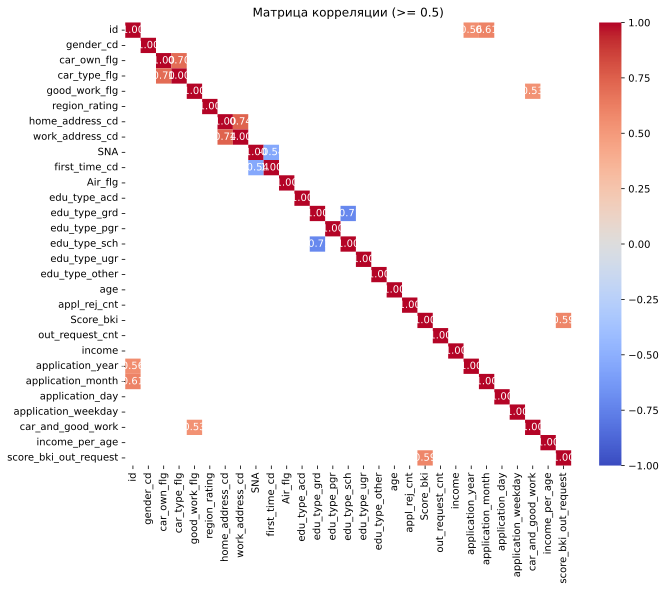

In [ ]:
correlation_matrix = data.corr()

# Пороговое значение корреляции
threshold = 0.5

# Маскирование значений ниже порога
masked_corr_matrix = correlation_matrix.copy()
masked_corr_matrix[:] = np.where(np.abs(correlation_matrix) >= threshold, correlation_matrix, np.nan)

# Визуализация отфильтрованной матрицы корреляции
plt.figure(figsize=(10, 8))
sns.heatmap(masked_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Матрица корреляции (>= ' + str(threshold) + ')')
plt.show()

### Алгоритмы

In [ ]:
X_train = data[:110148].set_index('id')
y_train = default[:110148].set_index('id')
X_val = data[110148:180816].set_index('id')
y_val = default[110148:].set_index('id')
X_test = data[180816:].set_index('id')

1. В качетсве бейзлайна посмотрим как решит эту задачу логистическая регрессия

In [ ]:
logreg = LogisticRegression(C=0.8,
                           random_state=0,
                           solver='lbfgs')
logreg.fit(X_train, y_train)
y_predict_proba = logreg.predict_proba(X_test)

make_csv_result(y_predict_proba[:, 1], X_test, "log_reg_result")

           score
id              
180817  0.316988
180818  0.520332
180819  0.287865
180820  0.489968
180821  0.181398
...          ...
205292  0.090250
205293  0.310423
205294  0.039282
205295  0.367946
205296  0.231667

[24480 rows x 1 columns]


### 2. XGBoost

In [ ]:
# !!!Запустить если нужно заново найти оптимальные параметры!!!

def objective(trial, X, y, cv_folds=5):
    """
    Целевая функция для оптимизации гиперпараметров XGBoost для задачи классификации.

    Args:
        trial: Объект Trial от Optuna, представляющий один набор гиперпараметров.
        X: Матрица признаков.
        y: Вектор целевой переменной.
        cv_folds: Количество фолдов для кросс-валидации.

    Returns:
        Среднее значение ROC AUC на кросс-валидации.
    """

    # Задаем пространство поиска гиперпараметров
    params = {
        "objective": "binary:logistic", # для бинарной классификации
        "eval_metric": "auc",
        "booster": "gbtree",
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "max_depth": trial.suggest_int("max_depth", 3, 9, step=2),
        "min_child_weight": trial.suggest_int("min_child_weight", 2, 10),
        "eta": trial.suggest_float("eta", 1e-8, 1.0, log=True),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "enable_categorical": True
    }

    # Создаем модель XGBoost с заданными гиперпараметрами
    model = XGBClassifier(**params)

    # Оцениваем модель с помощью кросс-валидации
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_val, y_val, scoring="roc_auc", cv=kf)

    # Возвращаем среднее значение ROC AUC
    return np.mean(scores)

def optimize_xgboost(X, y, n_trials=100):
    """
    Функция для запуска оптимизации гиперпараметров XGBoost с помощью Optuna для задачи классификации.

    Args:
        X: Матрица признаков.
        y: Вектор целевой переменной.
        n_trials: Количество итераций оптимизации.

    Returns:
        Лучшие гиперпараметры и лучшая модель.
    """

    # Создаем объект study
    study = optuna.create_study(direction="maximize") # максимизируем ROC AUC

    # Запускаем оптимизацию
    study.optimize(lambda trial: objective(trial, X, y), n_trials=n_trials)

    # Выводим результаты
    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    # Обучаем лучшую модель на всех данных
    best_params = trial.params
    best_params["objective"] = "binary:logistic"
    best_params["eval_metric"] = "auc"
    best_params["enable_categorical"] = True
    best_model = XGBClassifier(**best_params)
    best_model.fit(X_train, y_train)

    return best_params, best_model


In [ ]:
xgb_best_params, xgb_best_model = optimize_xgboost(X_val, y_val)

[I 2024-12-09 22:01:43,812] A new study created in memory with name: no-name-089cddc7-f97c-4477-850d-f3b0b905de5b
[I 2024-12-09 22:01:56,472] Trial 0 finished with value: 0.6692228671455694 and parameters: {'lambda': 0.0019882773271822324, 'alpha': 0.5353780382684935, 'subsample': 0.4851595937546489, 'colsample_bytree': 0.714464587700155, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.2478544684154172, 'gamma': 2.0658662971861232e-06, 'grow_policy': 'depthwise', 'n_estimators': 437}. Best is trial 0 with value: 0.6692228671455694.
[I 2024-12-09 22:02:12,726] Trial 1 finished with value: 0.7038731981998038 and parameters: {'lambda': 3.361964986899809e-05, 'alpha': 0.6400517482043377, 'subsample': 0.7983571923842838, 'colsample_bytree': 0.9471820170628751, 'max_depth': 5, 'min_child_weight': 10, 'eta': 2.526002093406196e-06, 'gamma': 9.759648176555112e-08, 'grow_policy': 'depthwise', 'n_estimators': 476}. Best is trial 1 with value: 0.7038731981998038.
[I 2024-12-09 22:02:42,274] Trial 

Number of finished trials:  100
Best trial:
  Value:  0.7260931333240279
  Params: 
    lambda: 2.2979213039799757e-08
    alpha: 7.735065651688954e-06
    subsample: 0.650902233926518
    colsample_bytree: 0.8189287790163462
    max_depth: 3
    min_child_weight: 8
    eta: 0.052371280222913104
    gamma: 3.949595086048105e-07
    grow_policy: depthwise
    n_estimators: 294


In [ ]:
best_params = {
    'lambda': 0.0003909165000095566,
    'alpha': 2.827814007948339e-08,
    'subsample': 0.6245893666261592,
    'colsample_bytree': 0.76997232526338,
    'max_depth': 3,
    'min_child_weight': 5,
    'eta': 0.05946942148080548,
    'gamma': 1.336041115418137e-08,
    'grow_policy': 'depthwise',
    'n_estimators': 202
}

best_params["objective"] = "binary:logistic"
best_params["eval_metric"] = "auc"
best_params["enable_categorical"] = True

xgb_best_model = XGBClassifier(**best_params)
xgb_best_model.fit(X_train, y_train)

XGBClassifier(alpha=2.827814007948339e-08, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.76997232526338, device=None,
              early_stopping_rounds=None, enable_categorical=True,
              eta=0.05946942148080548, eval_metric='auc', feature_types=None,
              gamma=1.336041115418137e-08, grow_policy='depthwise',
              importance_type=None, interaction_constraints=None,
              lambda=0.0003909165000095566, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=202, ...)

In [ ]:
y_predict_proba = xgb_best_model.predict_proba(X_test)[:, 1]
make_csv_result(y_predict_proba, X_test, "xgboost_optuned")

           score
id              
180817  0.103453
180818  0.118727
180819  0.084976
180820  0.125742
180821  0.055698
...          ...
205292  0.019438
205293  0.134875
205294  0.013722
205295  0.113084
205296  0.084352

[24480 rows x 1 columns]


### 3. LightGBM

In [ ]:

# !!!Запустить если нужно заново найти оптимальные параметры!!!

def objective(trial, X, y, cv_folds=5):
    """
    Целевая функция для оптимизации гиперпараметров LightGBM для задачи классификации.

    Args:
        trial: Объект Trial от Optuna, представляющий один набор гиперпараметров.
        X: Матрица признаков.
        y: Вектор целевой переменной.
        cv_folds: Количество фолдов для кросс-валидации.

    Returns:
        Среднее значение ROC AUC на кросс-валидации.
    """

    # Задаем пространство поиска гиперпараметров
    params = {
        "objective": "binary", # для бинарной классификации
        "metric": "auc",
        "boosting_type": "gbdt",
        "num_leaves": trial.suggest_int("num_leaves", 2, 125),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 50, 3000, step=50),
        "verbose": -1 # убираем вывод логов обучения
    }

    # Создаем модель LightGBM с заданными гиперпараметрами
    model = LGBMClassifier(**params)

    # Оцениваем модель с помощью кросс-валидации
    kf = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, scoring="roc_auc", cv=kf)

    # Возвращаем среднее значение ROC AUC
    return np.mean(scores)

def optimize_lightgbm(X, y, n_trials=50):
    """
    Функция для запуска оптимизации гиперпараметров LightGBM с помощью Optuna для задачи классификации.

    Args:
        X: Матрица признаков.
        y: Вектор целевой переменной.
        n_trials: Количество итераций оптимизации.

    Returns:
        Лучшие гиперпараметры и лучшая модель.
    """

    # Создаем объект study
    study = optuna.create_study(direction="maximize") # максимизируем ROC AUC

    # Запускаем оптимизацию
    study.optimize(lambda trial: objective(trial, X, y), n_trials=n_trials)

    # Выводим результаты
    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    # Обучаем лучшую модель на всех данных
    best_params = trial.params
    best_params["objective"] = "binary"
    best_params["metric"] = "auc"
    best_params["verbose"] = -1
    best_model = LGBMClassifier(**best_params)
    best_model.fit(X_train, y_train)

    return best_params, best_model

lgbm_best_params, lgbm_best_model = optimize_lightgbm(X_val, y_val)

[I 2024-12-09 22:51:48,161] A new study created in memory with name: no-name-7b93d27e-b150-4ebd-9db2-5e5683fdbad4
[I 2024-12-09 22:52:33,016] Trial 0 finished with value: 0.6889314574046068 and parameters: {'num_leaves': 75, 'learning_rate': 0.054464744655335684, 'n_estimators': 1200}. Best is trial 0 with value: 0.6889314574046068.
[I 2024-12-09 22:53:15,010] Trial 1 finished with value: 0.7201087451673608 and parameters: {'num_leaves': 90, 'learning_rate': 0.0057708287638327796, 'n_estimators': 700}. Best is trial 1 with value: 0.7201087451673608.
[I 2024-12-09 22:53:29,418] Trial 2 finished with value: 0.7215532077966367 and parameters: {'num_leaves': 16, 'learning_rate': 0.03483786126665994, 'n_estimators': 500}. Best is trial 2 with value: 0.7215532077966367.
[I 2024-12-09 22:54:55,685] Trial 3 finished with value: 0.7174634511231774 and parameters: {'num_leaves': 38, 'learning_rate': 0.00657160850951659, 'n_estimators': 2400}. Best is trial 2 with value: 0.7215532077966367.
[I 20

Number of finished trials:  50
Best trial:
  Value:  0.7242439430427223
  Params: 
    num_leaves: 10
    learning_rate: 0.025931037839144643
    n_estimators: 400


In [ ]:
best_params = {
    'num_leaves': 10,
    'learning_rate': 0.025931037839144643,
    'n_estimators': 400
}
best_params["objective"] = "binary"
best_params["metric"] = "auc"
best_params["verbose"] = -1
lgbm_best_model = LGBMClassifier(**best_params)
lgbm_best_model.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.025931037839144643, metric='auc',
               n_estimators=400, num_leaves=10, objective='binary', verbose=-1)

In [ ]:
y_predict_proba = lgbm_best_model.predict_proba(X_test)[:, 1]
make_csv_result(y_predict_proba, X_test, "lgbm optuned")

           score
id              
180817  0.096344
180818  0.119072
180819  0.082521
180820  0.123251
180821  0.057157
...          ...
205292  0.020699
205293  0.126466
205294  0.019213
205295  0.099383
205296  0.094297

[24480 rows x 1 columns]


### 4. CatBoost

In [ ]:
def objective_catboost(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 50, 500),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.5, log=True),
        "depth": trial.suggest_int("depth", 4, 16),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10.0, log=True),
        "random_strength": trial.suggest_float("random_strength", 1e-3, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Depthwise", "Lossguide"])
    }
    if params["grow_policy"] == "Lossguide":
      params["min_data_in_leaf"] = trial.suggest_int("min_data_in_leaf", 1, 100)
      params["max_leaves"] = trial.suggest_int("max_leaves", 2, 100)

    cat_features = ["gender_cd", "car_own_flg", "car_type_flg", "good_work_flg", "home_address_cd", "work_address_cd"]
    model = CatBoostClassifier(**params, random_state=42, verbose=0, auto_class_weights='Balanced', cat_features=cat_features)
    model.fit(X_val, y_val)
    y_pred = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, y_pred)


study_catboost = optuna.create_study(direction="maximize")
study_catboost.optimize(objective_catboost, n_trials=50, timeout=600)

best_params_catboost = study_catboost.best_params
print(f"\nЛучшие гиперпараметры для CatBoost: {best_params_catboost}")


[I 2024-12-09 22:01:28,919] A new study created in memory with name: no-name-f4576b6d-1a7e-4b69-ba49-a99cd9a994f9
[W 2024-12-09 22:01:32,750] Trial 0 failed with parameters: {'iterations': 98, 'learning_rate': 0.11624954362612687, 'depth': 9, 'l2_leaf_reg': 0.033674378487414496, 'random_strength': 0.0012838350627812913, 'bagging_temperature': 0.601202329273236, 'border_count': 65, 'grow_policy': 'Depthwise'} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-31-784dbe9d2bdb>", line 18, in objective_catboost
    model.fit(X_val, y_val)
  File "/usr/local/lib/python3.10/dist-packages/catboost/core.py", line 5245, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/usr/local/lib/python3.

KeyboardInterrupt: 

In [ ]:
cat_features = ["gender_cd", "car_own_flg", "car_type_flg", "good_work_flg", "home_address_cd", "work_address_cd"]
best_params = {
    'iterations': 390,
    'learning_rate': 0.05467964929149656,
    'depth': 14,
    'l2_leaf_reg': 0.05499940852270058,
    'random_strength': 0.21148517962423186,
    'bagging_temperature': 0.07811411040679372,
    'border_count': 126,
    'grow_policy': 'Depthwise'
    }
best_catboost = CatBoostClassifier(**best_params, random_state=42, verbose=0, auto_class_weights='Balanced', cat_features=cat_features)
best_catboost.fit(X_train, y_train)

In [ ]:
y_predict_proba = best_catboost.predict_proba(X_test)[:, 1]
make_csv_result(y_predict_proba, X_test, "catboost_optuned")

           score
id              
180817  0.000512
180818  0.000226
180819  0.000978
180820  0.023860
180821  0.000008
...          ...
205292  0.000005
205293  0.007543
205294  0.000016
205295  0.012349
205296  0.005006

[24480 rows x 1 columns]


### Блендинг

In [ ]:
random_forest = RandomForestClassifier(n_estimators=250,
                              max_depth=12,
                              min_samples_leaf=16
                              )
random_forest.fit(X_train, y_train)
y_predict_proba = random_forest.predict_proba(X_test)[:, 1]

make_csv_result(y_predict_proba, X_test, "rf")

           score
id              
180817  0.108990
180818  0.185073
180819  0.113923
180820  0.128298
180821  0.075016
...          ...
205292  0.039281
205293  0.130816
205294  0.022626
205295  0.160059
205296  0.118908

[24480 rows x 1 columns]


In [ ]:
# Предсказания на обучающей выборке (X_blend) - вероятности
xgb_pred_blend = xgb_best_model.predict_proba(X_val)[:, 1]
lgb_pred_blend = lgbm_best_model.predict_proba(X_val)[:, 1]
rf_pred_blend = random_forest.predict_proba(X_val)[:, 1]

# Предсказания на тестовой выборке (X_test) - вероятности
xgb_pred_test = xgb_best_model.predict_proba(X_test)[:, 1]
lgb_pred_test = lgbm_best_model.predict_proba(X_test)[:, 1]
rf_pred_test = random_forest.predict_proba(X_test)[:, 1]

# Создание DataFrame с метапризнаками для обучающей выборки
blend_train = pd.DataFrame({'xgb': xgb_pred_blend, 'lgb': lgb_pred_blend, 'rf': rf_pred_blend})

# Создание DataFrame с метапризнаками для тестовой выборки
blend_test = pd.DataFrame({'xgb': xgb_pred_test, 'lgb': lgb_pred_test, 'rf': rf_pred_test})

In [ ]:
# Обучение метаалгоритма
meta_model = LogisticRegression(C=0.8,
                           random_state=0,
                           solver='lbfgs')
meta_model.fit(blend_train, y_val)

LogisticRegression(C=0.8, random_state=0)

In [ ]:
final_predictions_proba = meta_model.predict_proba(blend_test)[:, 1]
make_csv_result(final_predictions_proba, X_test, "blending_xgb_rf_lgbm")

           score
id              
180817  0.079189
180818  0.107082
180819  0.075143
180820  0.102280
180821  0.058099
...          ...
205292  0.041866
205293  0.099298
205294  0.039543
205295  0.090439
205296  0.078336

[24480 rows x 1 columns]


Контест показал что такая реализация блендинга не показала результатов в улучшении метрик. Попробуем реализовать стекинг над lgbm, xgboost, random forest

### Стекинг

In [ ]:
X = data[:180816].set_index("id")
y = default[:180816].set_index('id')

In [ ]:
# Базовые модели
base_models = [
    ('rf', RandomForestClassifier(n_estimators=250,
                              max_depth=12,
                              min_samples_leaf=16
                              )),
    ('lgbm', LGBMClassifier({
        'objective' : 'binary',
        'eval_metric' : 'auc',
        'num_leaves': 10,
        'learning_rate': 0.025931037839144643,
        'n_estimators': 400,
    })),
    ('xgb', XGBClassifier(
        {
        'lambda': 0.0003909165000095566,
        'alpha': 2.827814007948339e-08,
        'subsample': 0.6245893666261592,
        'colsample_bytree': 0.76997232526338,
        'max_depth': 3,
        'min_child_weight': 5,
        'eta': 0.05946942148080548,
        'gamma': 1.336041115418137e-08,
        'grow_policy': 'depthwise',
        'n_estimators': 202,
        "objective" : "binary:logistic",
        "eval_metric" : "auc",
        "enable_categorical" :True
        })
    )
]
# Мета-модель
meta_model = LogisticRegression()

# Количество фолдов для кросс-валидации
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Функция для обучения базовых алгоритмов и формирования метапризнаков
def get_meta_features(base_models, X, y, X_test, n_folds=5):
    """
    Формирует метапризнаки для стекинга.

    Параметры:
    - base_models: список базовых моделей
    - X: обучающая выборка (признаки)
    - y: целевая переменная
    - X_test: тестовая выборка (признаки)
    - n_folds: количество фолдов для кросс-валидации

    Возвращает:
    - meta_features_train: метапризнаки для обучающей выборки
    - meta_features_test: метапризнаки для тестовой выборки
    """
    meta_features_train = np.zeros((X.shape[0], len(base_models)))
    meta_features_test = np.zeros((X_test.shape[0], len(base_models)))

    for i, name_model in enumerate(base_models):
        name, model = name_model
        print(f"Обучение базовой модели {i + 1}/{len(base_models)}: {model.__class__.__name__}")
        fold_test_preds = np.zeros((X_test.shape[0], n_folds))

        for fold, (train_idx, valid_idx) in enumerate(kf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[valid_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[valid_idx]

            # Клонируем модель, чтобы избежать "утечки" данных между фолдами
            model_fold = clone(model)

            # Обучаем модель на всех фолдах, кроме одного
            model_fold.fit(X_train, y_train)

            # Прогнозируем вероятности на валидационном фолде
            meta_features_train[valid_idx, i] = model_fold.predict_proba(X_val)[:, 1]

            # Прогнозируем вероятности на тестовой выборке
            fold_test_preds[:, fold] = model_fold.predict_proba(X_test)[:, 1]

        # Среднее значение по фолдам для тестовой выборки
        meta_features_test[:, i] = fold_test_preds.mean(axis=1)

    return meta_features_train, meta_features_test

# Получение метапризнаков
meta_features_train, meta_features_test = get_meta_features(base_models, X, y, X_test, n_folds=n_folds)

# Обучение мета-модели
meta_model.fit(meta_features_train, y)

print("Обучение стекинга завершено")

Обучение базовой модели 0/3: RandomForestClassifier


In [ ]:
# Предсказание на тестовой выборке
meta_predictions = meta_model.predict_proba(meta_features_test)[:, 1]

print("Предсказания мета-модели на тестовой выборке готовы.")

make_csv_result(meta_predictions, X_test, "stacking")